# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score


%matplotlib inline

In [2]:
# check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# read dataset from .txt file and remove first 8 row and set new header with this name: x, y, label
df = pd.read_csv("data.txt", skiprows=8, header=None, names=['x', 'y', 'label'])

# split dataset into the inputs x and the outputs y (labels)
X = df[['x', 'y']]
y = df['label']

print("shape of data frame is:", df.shape)
df

shape of data frame is: (4500, 3)


,x,y,label
0,4.780310,2.698320,0
1,-2.273710,5.750180,0
2,-4.817170,-2.209610,0
3,-9.526940,0.659360,0
4,1.864400,-5.019510,0
...,...,...,...
4495,-4.327500,-0.210256,1
4496,-1.077300,1.279540,1
4497,-2.377350,-3.078130,1
4498,0.508152,0.432983,1


In [4]:
# convert data to pytorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device).view(-1, 1)


# Split the dataset into training, testing, and validation sets
# Tranin: 70%, Test: 20%, Validation: 10%
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)


print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 3150
Testing set size: 900
Validation set size: 450


In [5]:
# divide data into two classes
class0 = X_tensor[y_tensor.flatten() == 0]
class1 = X_tensor[y_tensor.flatten() == 1]

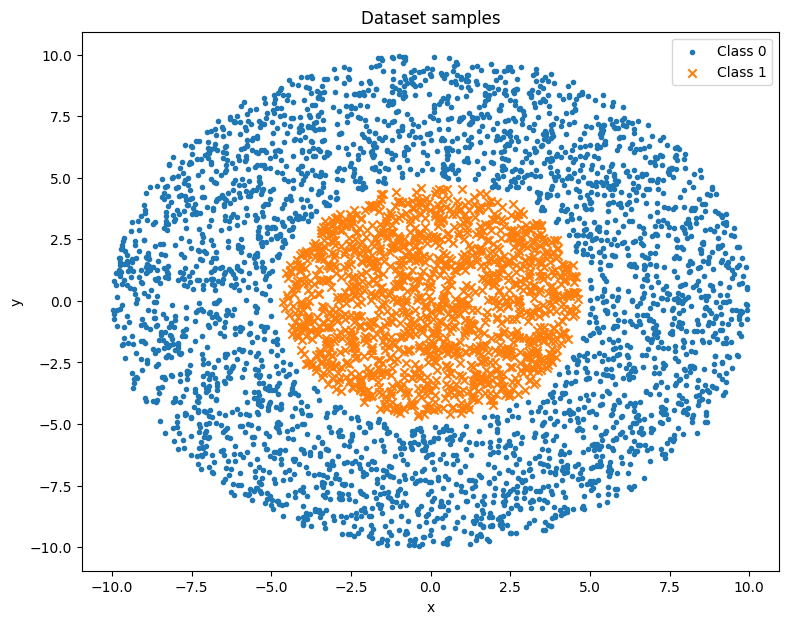

In [6]:
# Plot data
plt.figure(figsize=(9, 7))

plt.scatter(class0[:, 0].cpu().numpy(), class0[:, 1].cpu().numpy(), label="Class 0", marker='.')
plt.scatter(class1[:, 0].cpu().numpy(), class1[:, 1].cpu().numpy(), label="Class 1", marker='x')

plt.xlabel('x')
plt.ylabel('y')
plt.title("Dataset samples")
plt.legend()

plt.show()

In [7]:
# define single layer perceptron class using pytorch
class single_layer_perceptron(nn.Module):
    def __init__(self, input_size):
        super(single_layer_perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

In [8]:
# initialize parameters of model

model = single_layer_perceptron(X_train.size(1)).to(device) # create model
epochs = 100

# define loss function and optimizer
criterion = nn.MSELoss() # unsing mean squared error for loss function
optimizer = optim.SGD(model.parameters(), lr=0.01) # using stochastic gradient descent for optimization

# convert labels to integer type
y_train = y_train.long()
y_test = y_test.long()
y_val = y_val.long()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
# train phase 

for epoch in range(epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.float())

    # backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate accuracy
    predicted = torch.round(outputs.data)
    correct = (predicted == y_train).sum().item()
    train_accuracy = correct / y_train.size(0)
    train_f1 = f1_score(y_train.cpu().numpy(), predicted.cpu().numpy())

    # calculate loss and accuracy for validation set
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, y_val.float())
    val_predicted = torch.round(val_outputs.data)
    val_correct = (val_predicted == y_val).sum().item()
    val_accuracy = val_correct / y_val.size(0)
    val_f1 = f1_score(y_val.cpu().numpy(), val_predicted.cpu().numpy())

    # store losses and accuracies
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}")
print('-'*80)
print(f"Validation Loss: {sum(val_losses) / len(val_losses):.4f}, Validation Accuracy: {sum(val_accuracies) / len(val_accuracies):.4f}, Validation F1 Score: {val_f1:.4f}")
print("-"*80)

Epoch 1/100, Loss: 0.3637, Accuracy: 0.4959, F1 Score: 0.3807
Epoch 2/100, Loss: 0.3631, Accuracy: 0.4956, F1 Score: 0.3805
Epoch 3/100, Loss: 0.3625, Accuracy: 0.4952, F1 Score: 0.3799
Epoch 4/100, Loss: 0.3619, Accuracy: 0.4952, F1 Score: 0.3799
Epoch 5/100, Loss: 0.3613, Accuracy: 0.4959, F1 Score: 0.3802
Epoch 6/100, Loss: 0.3607, Accuracy: 0.4962, F1 Score: 0.3803
Epoch 7/100, Loss: 0.3601, Accuracy: 0.4959, F1 Score: 0.3802
Epoch 8/100, Loss: 0.3595, Accuracy: 0.4956, F1 Score: 0.3800
Epoch 9/100, Loss: 0.3589, Accuracy: 0.4956, F1 Score: 0.3800
Epoch 10/100, Loss: 0.3582, Accuracy: 0.4952, F1 Score: 0.3799
Epoch 11/100, Loss: 0.3576, Accuracy: 0.4952, F1 Score: 0.3799
Epoch 12/100, Loss: 0.3569, Accuracy: 0.4943, F1 Score: 0.3785
Epoch 13/100, Loss: 0.3563, Accuracy: 0.4943, F1 Score: 0.3785
Epoch 14/100, Loss: 0.3556, Accuracy: 0.4946, F1 Score: 0.3786
Epoch 15/100, Loss: 0.3549, Accuracy: 0.4946, F1 Score: 0.3781
Epoch 16/100, Loss: 0.3543, Accuracy: 0.4946, F1 Score: 0.3781
E

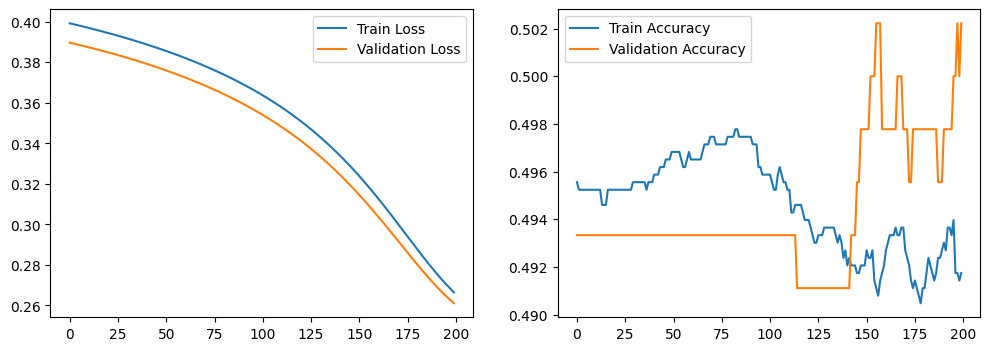

In [11]:
# plot training loss and accuracy

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()

In [12]:
# test phase
test_outputs = model(X_test)
test_loss = criterion(test_outputs, y_test.float())
test_predicted = torch.round(test_outputs.data)
test_correct = (test_predicted == y_test).sum().item()
test_accuracy = test_correct / y_test.size(0)
test_f1 = f1_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
test_cm = confusion_matrix(y_test.cpu().numpy(), test_predicted.cpu().numpy())


# calculate F1 score and confusion matrix for training and validation set
train_predicted = torch.round(model(X_train).data)
train_f1 = f1_score(y_train.cpu().numpy(), train_predicted.cpu().numpy())
train_cm = confusion_matrix(y_train.cpu().numpy(), train_predicted.cpu().numpy())
val_cm = confusion_matrix(y_val.cpu().numpy(), val_predicted.cpu().numpy())

print(f"Test loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print("Final weights:", model.fc.weight.data)

Test loss: 0.2654, Test Accuracy: 0.4956, Test F1 Score: 0.3677
Final weights: tensor([[ 0.1124, -0.0201]], device='cuda:0')


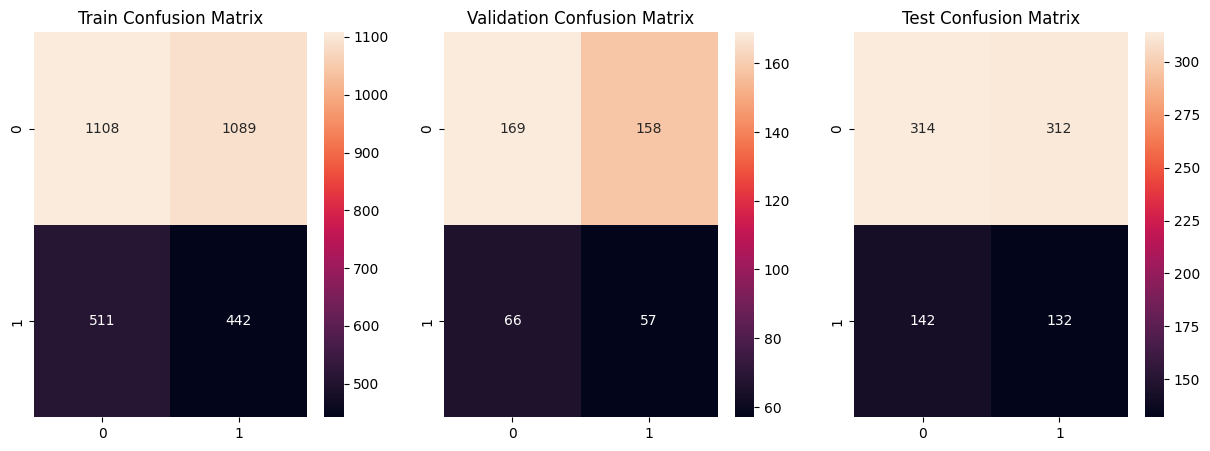

In [13]:
# plot confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(train_cm, annot=True, fmt='d', ax=axs[0])
axs[0].set_title("Train Confusion Matrix")

sns.heatmap(val_cm, annot=True, fmt='d', ax=axs[1])
axs[1].set_title("Validation Confusion Matrix")

sns.heatmap(test_cm, annot=True, fmt='d', ax=axs[2])
axs[2].set_title("Test Confusion Matrix")

plt.show()

## Part B:
### Create high order fitures and train the model with them
### In this part we create $x^2, x^3$ as a new input fitures

In [37]:
# create high order fitures
X2_tensor = X_tensor ** 2
X3_tensor = X_tensor ** 3

### Split datasets 

In [21]:
# Split the dataset into training, testing, and validation sets
# Tranin: 70%, Test: 20%, Validation: 10%

X2_train, X2_temp, y_train, y_temp = train_test_split(X2_tensor, y_tensor, test_size=0.3, random_state=42) 
X2_val, X2_test, y_val, y_test = train_test_split(X2_temp, y_temp, test_size=2/3, random_state=42)

X3_train, X3_temp, y_train, y_temp = train_test_split(X3_tensor, y_tensor, test_size=0.3, random_state=42) 
X3_val, X3_test, y_val, y_test = train_test_split(X3_temp, y_temp, test_size=2/3, random_state=42)

In [38]:
# divide data into two classes
X2_class0 = X2_tensor[y_tensor.flatten() == 0]
X2_class1 = X2_tensor[y_tensor.flatten() == 1]

X3_class0 = X3_tensor[y_tensor.flatten() == 0]
X3_class1 = X3_tensor[y_tensor.flatten() == 1]


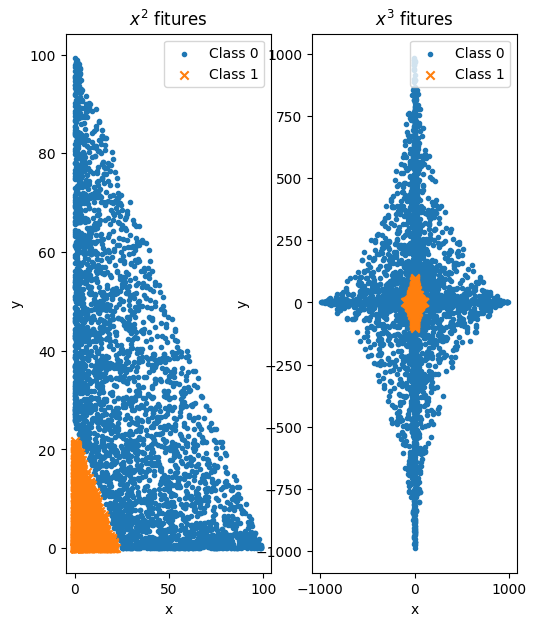

In [44]:
# Plot data
plt.figure(figsize=(9, 7))

plt.subplot(1, 3, 1)
plt.title("$x^2$ fitures")
plt.scatter(X2_class0[:, 0].cpu().numpy(), X2_class0[:, 1].cpu().numpy(), label="Class 0", marker='.')
plt.scatter(X2_class1[:, 0].cpu().numpy(), X2_class1[:, 1].cpu().numpy(), label="Class 1", marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()


plt.subplot(1, 3, 2)
plt.title("$x^3$ fitures")
plt.scatter(X3_class0[:, 0].cpu().numpy(), X3_class0[:, 1].cpu().numpy(), label="Class 0", marker='.')
plt.scatter(X3_class1[:, 0].cpu().numpy(), X3_class1[:, 1].cpu().numpy(), label="Class 1", marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

In [51]:
# initialize parameters of model

model = single_layer_perceptron(X2_train.size(1)).to(device) # create model


X2_train_losses = []
X2_train_accuracies = []
X2_val_losses = []
X2_val_accuracies = []
X2_test_losses = []
X2_test_accuracies = []


X3_train_losses = []
X3_train_accuracies = []
X3_val_losses = []
X3_val_accuracies = []
X3_test_losses = []
X3_test_accuracies = []

In [55]:
# train phase 
for epoch in range(epochs):
    # forward pass
    outputs = model(X2_train)
    loss = criterion(outputs, y_train.float())

    # backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate accuracy
    predicted = torch.round(outputs.data)
    correct = (predicted == y_train).sum().item()
    train_accuracy = correct / y_train.size(0)
    train_f1 = f1_score(y_train.cpu().numpy(), predicted.cpu().numpy())

    # calculate loss and accuracy for validation set
    val_outputs = model(X2_val)
    val_loss = criterion(val_outputs, y_val.float())
    val_predicted = torch.round(val_outputs.data)
    val_correct = (val_predicted == y_val).sum().item()
    val_accuracy = val_correct / y_val.size(0)
    val_f1 = f1_score(y_val.cpu().numpy(), val_predicted.cpu().numpy())

    # store losses and accuracies
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}")
print('-'*80)
print(f"Validation Loss: {sum(val_losses) / len(val_losses):.4f}, Validation Accuracy: {sum(val_accuracies) / len(val_accuracies):.4f}, Validation F1 Score: {val_f1:.4f}")
print("-"*80)

Epoch 1/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 2/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 3/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 4/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 5/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 6/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 7/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 8/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 9/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 10/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 11/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 12/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 13/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 14/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 15/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
Epoch 16/100, Loss: 0.4977, Accuracy: 0.4032, F1 Score: 0.3233
E